# ELEN0071-1 - Homework 2

## Instructions

- This homework must be carried out in groups of maximum 2 students.

- Each group must write a Python notebook (named `notebook.ipynb`) that contains the answer to all questions of the homework. Each group must submit a single *zip* archive  that contains the notebook and all input/output associated files on [Gradescope](https://www.gradescope.com/). 

- This homework is due by May 20, 2022 at 10pm. This is a hard deadline.


## Gradescope submission

- Each student should register on [Gradescope](https://www.gradescope.com/) using his or her `@student.uliege.be` address. If you don't see the class ELEN0071-1 on your dashboard, contact us on [Ed](https://edstem.org/us/dashboard) as soon as possible (don't wait the day before the deadline ;-). 

- Each group should submit a *zip* archive on [Gradescope](https://www.gradescope.com/). Make sure that all group members are correctly added to the submission!

If you are not familiar with Gradescope, please click on each step of the following guideline:
- [Code submission](https://help.gradescope.com/article/ccbpppziu9-student-submit-work#code_submissions), 
- [Adding group members](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

## Question 1 

The University Hospital of Liège invited you to assist in the analysis of the electroencephalogram (EEG) of a volunteer progressively drugged with Propofol, a famous anesthetic. They need you to interpret the changes in the patient's neuronal activity throughout the experiment. Specifically, your task is to determine how neuronal activity is modified during anesthesia. To do so, doctors gave you two signals:
- `EEG.npy`, the raw EEG signal, in µV.
- `propofol.npy`, the concentration of anesthesia in the patient's blood, in µg/ml.
Both signals were sampled at 250 Hz. To fulfill your task, follow the procedure below:

**a)** Load and display the EEG data in the time domain. Your time axis should be expressed in minutes.

**b)** Compute the spectrogram of the EEG signal using the function you wrote to answer Question 2c of Lab 2 (i.e. **WITHOUT using the function `scipy.signal.spectrogram` or any other pre-made function**). You must use a rectangular window, $N$ samples per segment, $N/8$ samples to overlap between segments, and no padding (i.e., `window='boxcar', nperseg=N, noverlap=N//8, nfft=N`). 
- Plot the spectrogram of the EEG and the Propofol sequence on top of each other to ease the parallel between the two figures. Both time axis should be expressed in minutes. 
- Discuss the choice of the parameter $N$ corresponding to the length of your window.

*Suggestions* : Use `matplotlib.pyplot.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True, constrained_layout=True)` where the first row is for the spectrogram and the second for the Propofol data. Set `vmin` and `vmax` wisely when using the function `matplotlib.pyplot.pcolormesh`. Use the same values across all of the spectrograms needed for this homework. 

**c)** Progressive loss of consciousness is marked by the appearance of new frequencies in the EEG spectrum. Based on your interpretation of the spectrogram through visual inspection, modify your previous Propofol plot to label the loss and the recovery of consciousness: 
- add a vertical dotted line labeled LC at the time index corresponding approximately to the loss of consciousness of the patient,
- add a vertical dotted line labeled RC at the time index corresponding approximately to the recovery of consciousness.

**d)** We can see that the EEG data is corrupted by white noise (i.e. noise power distributed over a large range of frequencies) during the first five minutes of the EEG recording. Do you notice another type of noise? Describe it.

If the EEG data is affected by noise with a constant frequency, your next task is to filter it by following the steps below:

**e)** Design a second-order notch filter for the adequate frequency **WITHOUT USING THE FUNCTION `scipy.signal.iirnotch`**. Do so by placing poles and zeros on the imaginary plane (pay attention that your filter must have a real-valued impulse response). Make sure that $20 \cdot \text{log}_{10}\left(|H(e^{j\omega})|\right)\approx 0$ dB for $\omega$ outside of the stopband of your filter. Show the pole-zero plot and the Bode plots of your filter.

*Bonus (+1/20): place the poles and zeros such that your notch filter has a 3dB-bandwidth of 5Hz. An illustration of the 3dB-bandwidth is shown in the figure below for a notch filter with a cut-off frequency $F_{cut}$.*
<img src="./figure/HW2.jpg"  alt="drawing" width="550"/>

**f)** Filter the EEG signal using your design and the function `scipy.signal.filtfilt`. Show the result by plotting the spectrogram of the filtered EEG.

**g)** Plot 2-second snapshots of the EEG data in the time domain at 70, 1000, and 2200 seconds before and after the filtering. 

#### Question 1.a)

Text(0.5, 0, 'Time in min')

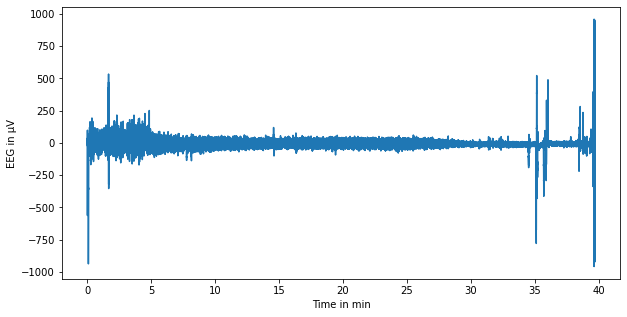

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import windows
from scipy.optimize import bisect

fs = 250 # signals frequency

# EEG : Load and plot

eeg = np.load('./data/EEG.npy')
N = len(eeg)
t = np.arange(0,N)/fs

fig, axis = plt.subplots(figsize=(10,5))
axis.plot(t/60,eeg)
axis.set_ylabel('EEG in µV')
axis.set_xlabel('Time in min')

#### Question 1.b)

Text(0, 0.5, 'Concentration in µg/ml')

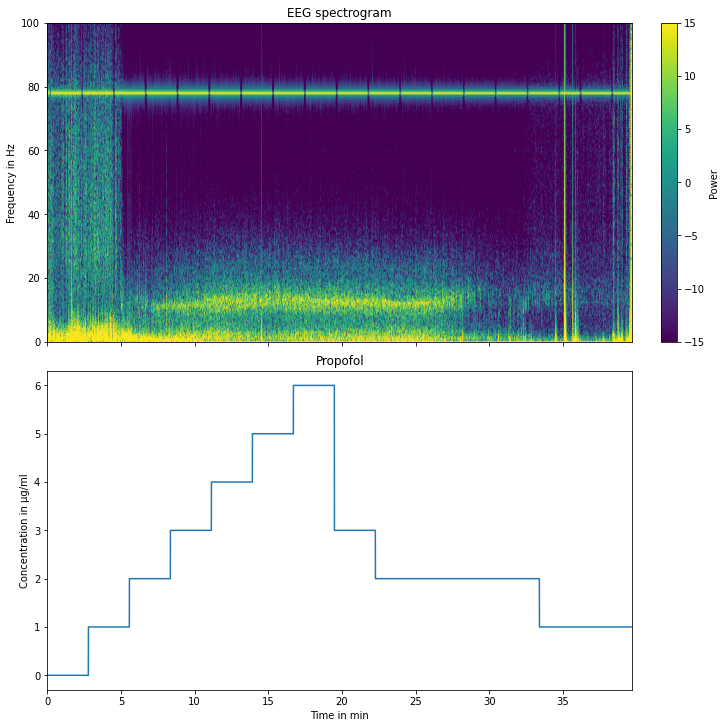

In [5]:
# Our version of the signal.spectrogram function from Lab2
def new_spectrogram(x, fs=8, window='rect', n_seg=8, n_overlap=1, nfft=1):
  step = np.floor(n_seg-n_overlap)
  n_segs = int(np.floor((len(x)-n_seg+step)/step))

  if window != 'rect':
    win_type = windows.get_window(window,n_seg,False)
  else:
    win_type = np.ones((n_seg,))

  temp_spectrogram = []
  for i in range(n_segs):
    segment = x[int(i*step):int(n_seg+i*step)]
    seg_in_window = segment*win_type
    spectrum = np.fft.fft(seg_in_window,nfft)
    power_spectrum = spectrum * np.conj(spectrum)
    temp_spectrogram.append(power_spectrum)

  Sxx = np.transpose(np.array(temp_spectrogram))
  sxx_scale = 1.0 / win_type.sum()**2
  Sxx = Sxx * sxx_scale

  f = np.fft.fftfreq(nfft, d=1/fs)
  f = f[:(nfft+1)//2]
  Sxx = Sxx[:(nfft+1)//2,:]

  Sxx[1:,:] = 2 * Sxx[1:,:]
  Sxx = Sxx / fs
  Sxx = Sxx * win_type.sum()**2 / (win_type*win_type).sum()

  t = np.arange(n_segs) * step/fs

  return f,t,Sxx

# Propofol load

propofol = np.load('./data/propofol.npy')

# Plot the spectrogram and propofol concentration

window_samples = 2 * fs

f, t_spect, Sxx = new_spectrogram(eeg, fs, window='boxcar', n_seg=window_samples, n_overlap=window_samples//8, nfft=window_samples)
Sxx = Sxx.real

fig, (axis_1, axis_2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10), sharex=True, constrained_layout=True)

eeg_plot = axis_1.pcolormesh(t_spect/60, f, 10*np.log10(Sxx), vmin=-15, vmax=15, shading='gouraud')
eeg_bar = fig.colorbar(eeg_plot, ax=axis_1)
eeg_bar.set_label('Power')
axis_1.set_title('EEG spectrogram')
axis_1.set_ylabel('Frequency in Hz')
axis_1.set_xlim((t[0]/60,t[-1]/60))
axis_1.set_ylim((0,100))

axis_2.plot(t/60, propofol)
axis_2.set_title('Propofol')
axis_2.set_xlabel('Time in min')
axis_2.set_ylabel('Concentration in µg/ml')


#### Question 1.c)

Text(0, 0.5, 'Concentration in µg/ml')

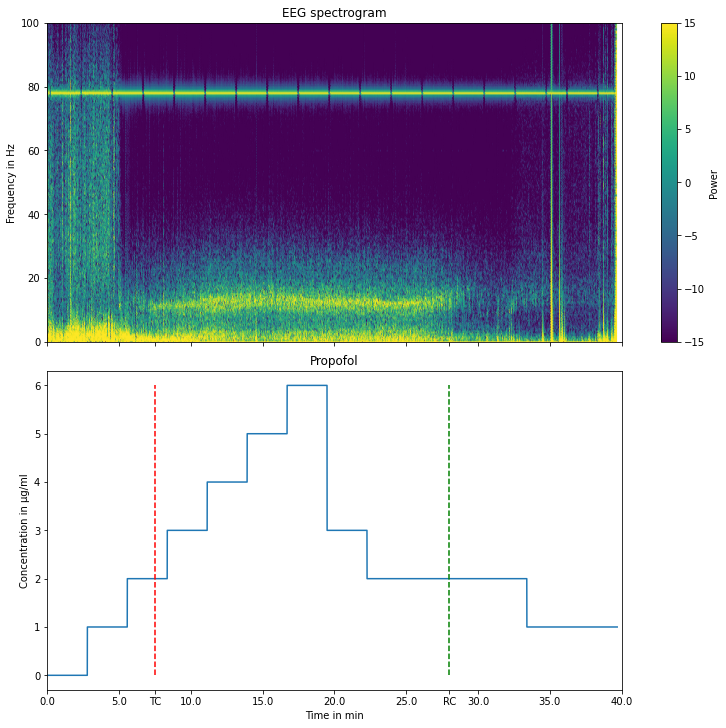

In [6]:
# Hardcoded values after looking at the spectrogram
TC = 7.5
RC = 28

y_profonol = [np.min(propofol), np.max(propofol)]

fig, (axis_1, axis_2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10), sharex=True, constrained_layout=True)

eeg_plot = axis_1.pcolormesh(t_spect/60, f, 10*np.log10(Sxx), vmin=-15, vmax=15, shading='gouraud')
eeg_bar = fig.colorbar(eeg_plot, ax=axis_1)
eeg_bar.set_label('Power')
axis_1.set_title('EEG spectrogram')
axis_1.set_ylabel('Frequency in Hz')
axis_1.set_xlim((t[0]/60,t[-1]/60))
axis_1.set_ylim((0,100))

# Add TC and RC to xlabels

axis_2.plot(t/60, propofol)
axis_2.plot([TC,TC], y_profonol, '--r')
axis_2.plot([RC,RC], y_profonol, '--g')
x_ticks = list(plt.xticks()[0])
x_labels = [str(i) for i in x_ticks] + ['TC', 'RC']
x_ticks += [TC,RC]
axis_2.set_xticks(x_ticks,x_labels)
axis_2.set_title('Propofol')
axis_2.set_xlabel('Time in min')
axis_2.set_ylabel('Concentration in µg/ml')

#### Question 1.d)

By looking at the spectrogram of the EEG, we can see the white noise during the 5 first minutes discussed in the instructions.

But we can also see a noise with a constant frequency a little below 80 Hz (~ 78Hz)

#### Question 1.e)

Text(0, 0.5, 'Phase in °')

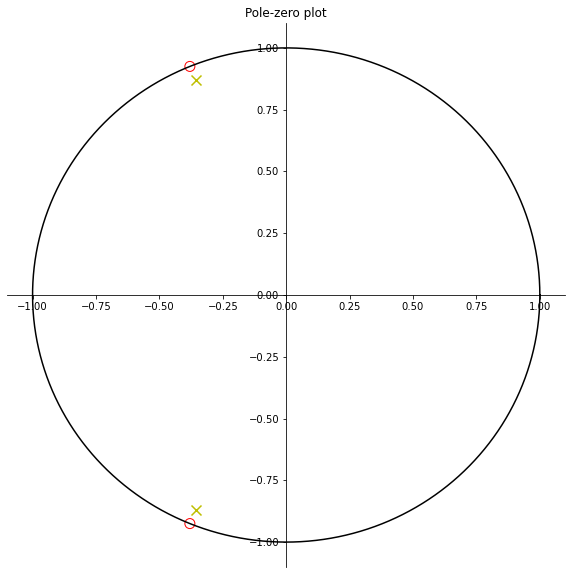

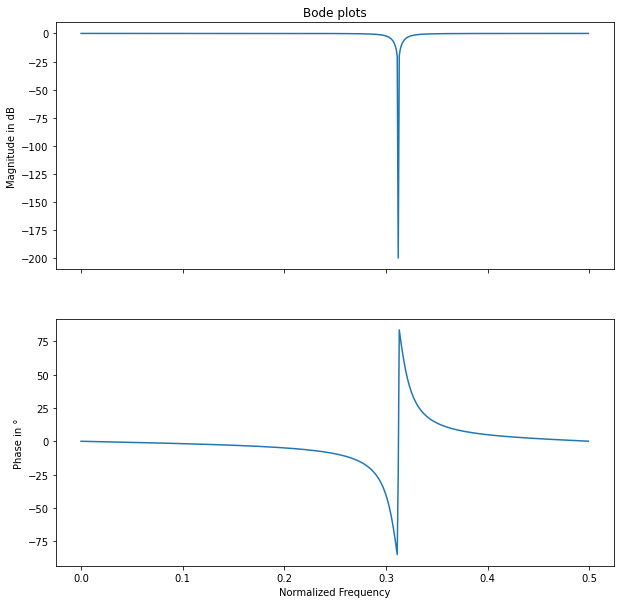

In [7]:
# Computes the transfer function using b,a and z
def transfer_eval(b,a,z):
  z_shape = np.shape(z)
  num = np.zeros(z_shape, dtype=np.complex128)
  denom = np.zeros(z_shape, dtype=np.complex128)

  for i, b in enumerate(b):
    num += b * z**(-i)
  for j, a in enumerate(a):
    denom += a * z**(-j)

  return num/denom

# Computes the b and a coefficients for the transfer function using the zeros and poles
def transfer_coefs(zeros,poles):
  a = [1, -np.real((poles[0] + poles[1])), np.real(poles[0] * poles[1])]
  b = [1, -np.real((zeros[0] + zeros[1])), np.real(zeros[0] * zeros[1])]

  K = np.max([np.abs(transfer_eval(b,a,-1)), np.abs(transfer_eval(b,a,1))])

  if 0.0 < K:
    b = b/K

  return b,a

# Creation of our notch filter to remove the desired frequency f_remove
def notch_filter(fs, f_remove, bw3):
  omega = 2 * np.pi * f_remove/fs
  zeros = [np.exp(1j*omega), np.exp(-1j*omega)]
  bw_upbound = np.exp(1j*(omega + 2 * np.pi * bw3/(2*fs)))

  def power_3db(r):
    poles = [r * np.exp(1j * omega), r * np.exp(-1j * omega)]
    b, a = transfer_coefs(zeros,poles)
    power_upbound = np.abs(transfer_eval(b, a, bw_upbound))**2
    return power_upbound - 0.5

  r = bisect(power_3db, 0.001, 0.999)
  poles = [r * np.exp(1j * omega), r * np.exp(-1j * omega)]
  b, a = transfer_coefs(zeros,poles)
  return b, a, zeros, poles


bw3 = 5
f_remove = 78 # Hardcoded value after looking at the spectrogram

b, a, zeros, poles = notch_filter(fs, f_remove, bw3) # Compute the notch filter using our values

# Pole-zero plot

omega = np.arange(0, 2 * np.pi, 0.001)
circle = np.exp(1j * omega)

fig, axis = plt.subplots(figsize=(10,10))
axis.set_title('Pole-zero plot')
axis.plot(np.real(circle), np.imag(circle), c='k')
axis.scatter(np.real(zeros), np.imag(zeros), s=100, facecolors='none', edgecolors='r')
axis.scatter(np.real(poles), np.imag(poles), s=100, c='y', marker='x')
axis.spines['top'].set_color('none')
axis.spines['right'].set_color('none')
axis.spines['bottom'].set_position('center')
axis.spines['left'].set_position('center')

# Bode

f = np.arange(0.0,0.5,0.001)
z = np.exp(1j * 2 * np.pi * f)
H = transfer_eval(b, a, z)
power_spect = np.abs(H)**2
phase = np.angle(H, deg=True)

fig, (axis_1, axis_2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10), sharex=True)
axis_1.set_title('Bode plots')
axis_1.plot(f, 10 * np.log10(power_spect + 10**(-20)))
axis_1.set_ylabel('Magnitude in dB')
axis_2.plot(f,phase)
axis_2.set_xlabel('Normalized Frequency')
axis_2.set_ylabel('Phase in °')



#### Question 1.f)

(0.0, 100.0)

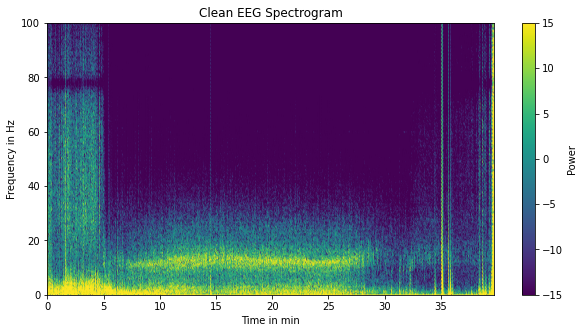

In [11]:
filtered_eeg = signal.filtfilt(b,a,eeg) # Compute the clean signal using our a and b coefficients

f_clean, t_spect_clean, Sxx_clean = new_spectrogram(filtered_eeg, fs, window='boxcar', n_seg=window_samples, n_overlap=window_samples//8, nfft=window_samples)
Sxx_clean = Sxx_clean.real

fig, axis = plt.subplots(figsize=(10,5))

axis.set_title('Clean EEG Spectrogram')
clean_eeg = axis.pcolormesh(t_spect_clean/60, f_clean, 10*np.log10(Sxx_clean), vmin=-15, vmax=15, shading='gouraud')
cbar = fig.colorbar(clean_eeg, ax=axis)
cbar.set_label('Power')
axis.set_xlabel('Time in min')
axis.set_ylabel('Frequency in Hz')
axis.set_xlim((t[0]/60,t[-1]/60))
axis.set_ylim((0,100))

#### Question 1.g)

(-60.0, 60.0)

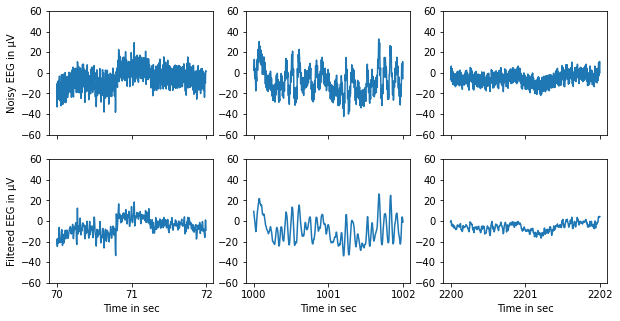

In [21]:
t0 = 70
t1 = 1000
t2 = 2200
window = 2 # 2 second window

fig , axis = plt.subplots(nrows=2, ncols=3, sharex='col',figsize=(10,5))

axis[0,0].plot(t[t0*fs:(t0+window)*fs], eeg[t0*fs:(t0+window)*fs])
axis[1,0].plot(t[t0*fs:(t0+window)*fs], filtered_eeg[t0*fs:(t0+window)*fs])
axis[0,1].plot(t[t1*fs:(t1+window)*fs], eeg[t1*fs:(t1+window)*fs])
axis[1,1].plot(t[t1*fs:(t1+window)*fs], filtered_eeg[t1*fs:(t1+window)*fs])
axis[0,2].plot(t[t2*fs:(t2+window)*fs], eeg[t2*fs:(t2+window)*fs])
axis[1,2].plot(t[t2*fs:(t2+window)*fs], filtered_eeg[t2*fs:(t2+window)*fs])

axis[1,0].set_xlabel('Time in sec')
axis[1,1].set_xlabel('Time in sec')
axis[1,2].set_xlabel('Time in sec')

axis[1,0].set_xticks(np.arange(t0,t0+window+0.1,window/2))
axis[1,1].set_xticks(np.arange(t1,t1+window+0.1,window/2))
axis[1,2].set_xticks(np.arange(t2,t2+window+0.1,window/2))

axis[0,0].set_ylabel('Noisy EEG in µV')
axis[1,0].set_ylabel('Filtered EEG in µV')

axis[0,0].set_ylim((-60,60))
axis[0,1].set_ylim((-60,60))
axis[0,2].set_ylim((-60,60))
axis[1,0].set_ylim((-60,60))
axis[1,1].set_ylim((-60,60))
axis[1,2].set_ylim((-60,60))
